In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image

In [2]:
res = pd.read_pickle("results.pkl")
res[res == ""] = np.nan
res.columns = [col.replace("_", " ").title() for col in res.columns]

cnt = pd.read_pickle("counts.pkl").rename(columns={"qry": "Query", "cnt": "Result Count"})

# Introduction

Good day! This project is intended to demonstrate the performance of a simple web scrape. It follows a real Upwork project that you can see <a href="https://www.upwork.com/jobs/~01b9b115cb4d63ef6c" target="_blank">here</a>. (I did not actually take this job, so I'm doing it without speaking to the client using only the information in the posting.)

The job is asking for an extraction of all possible contacts from this web form:

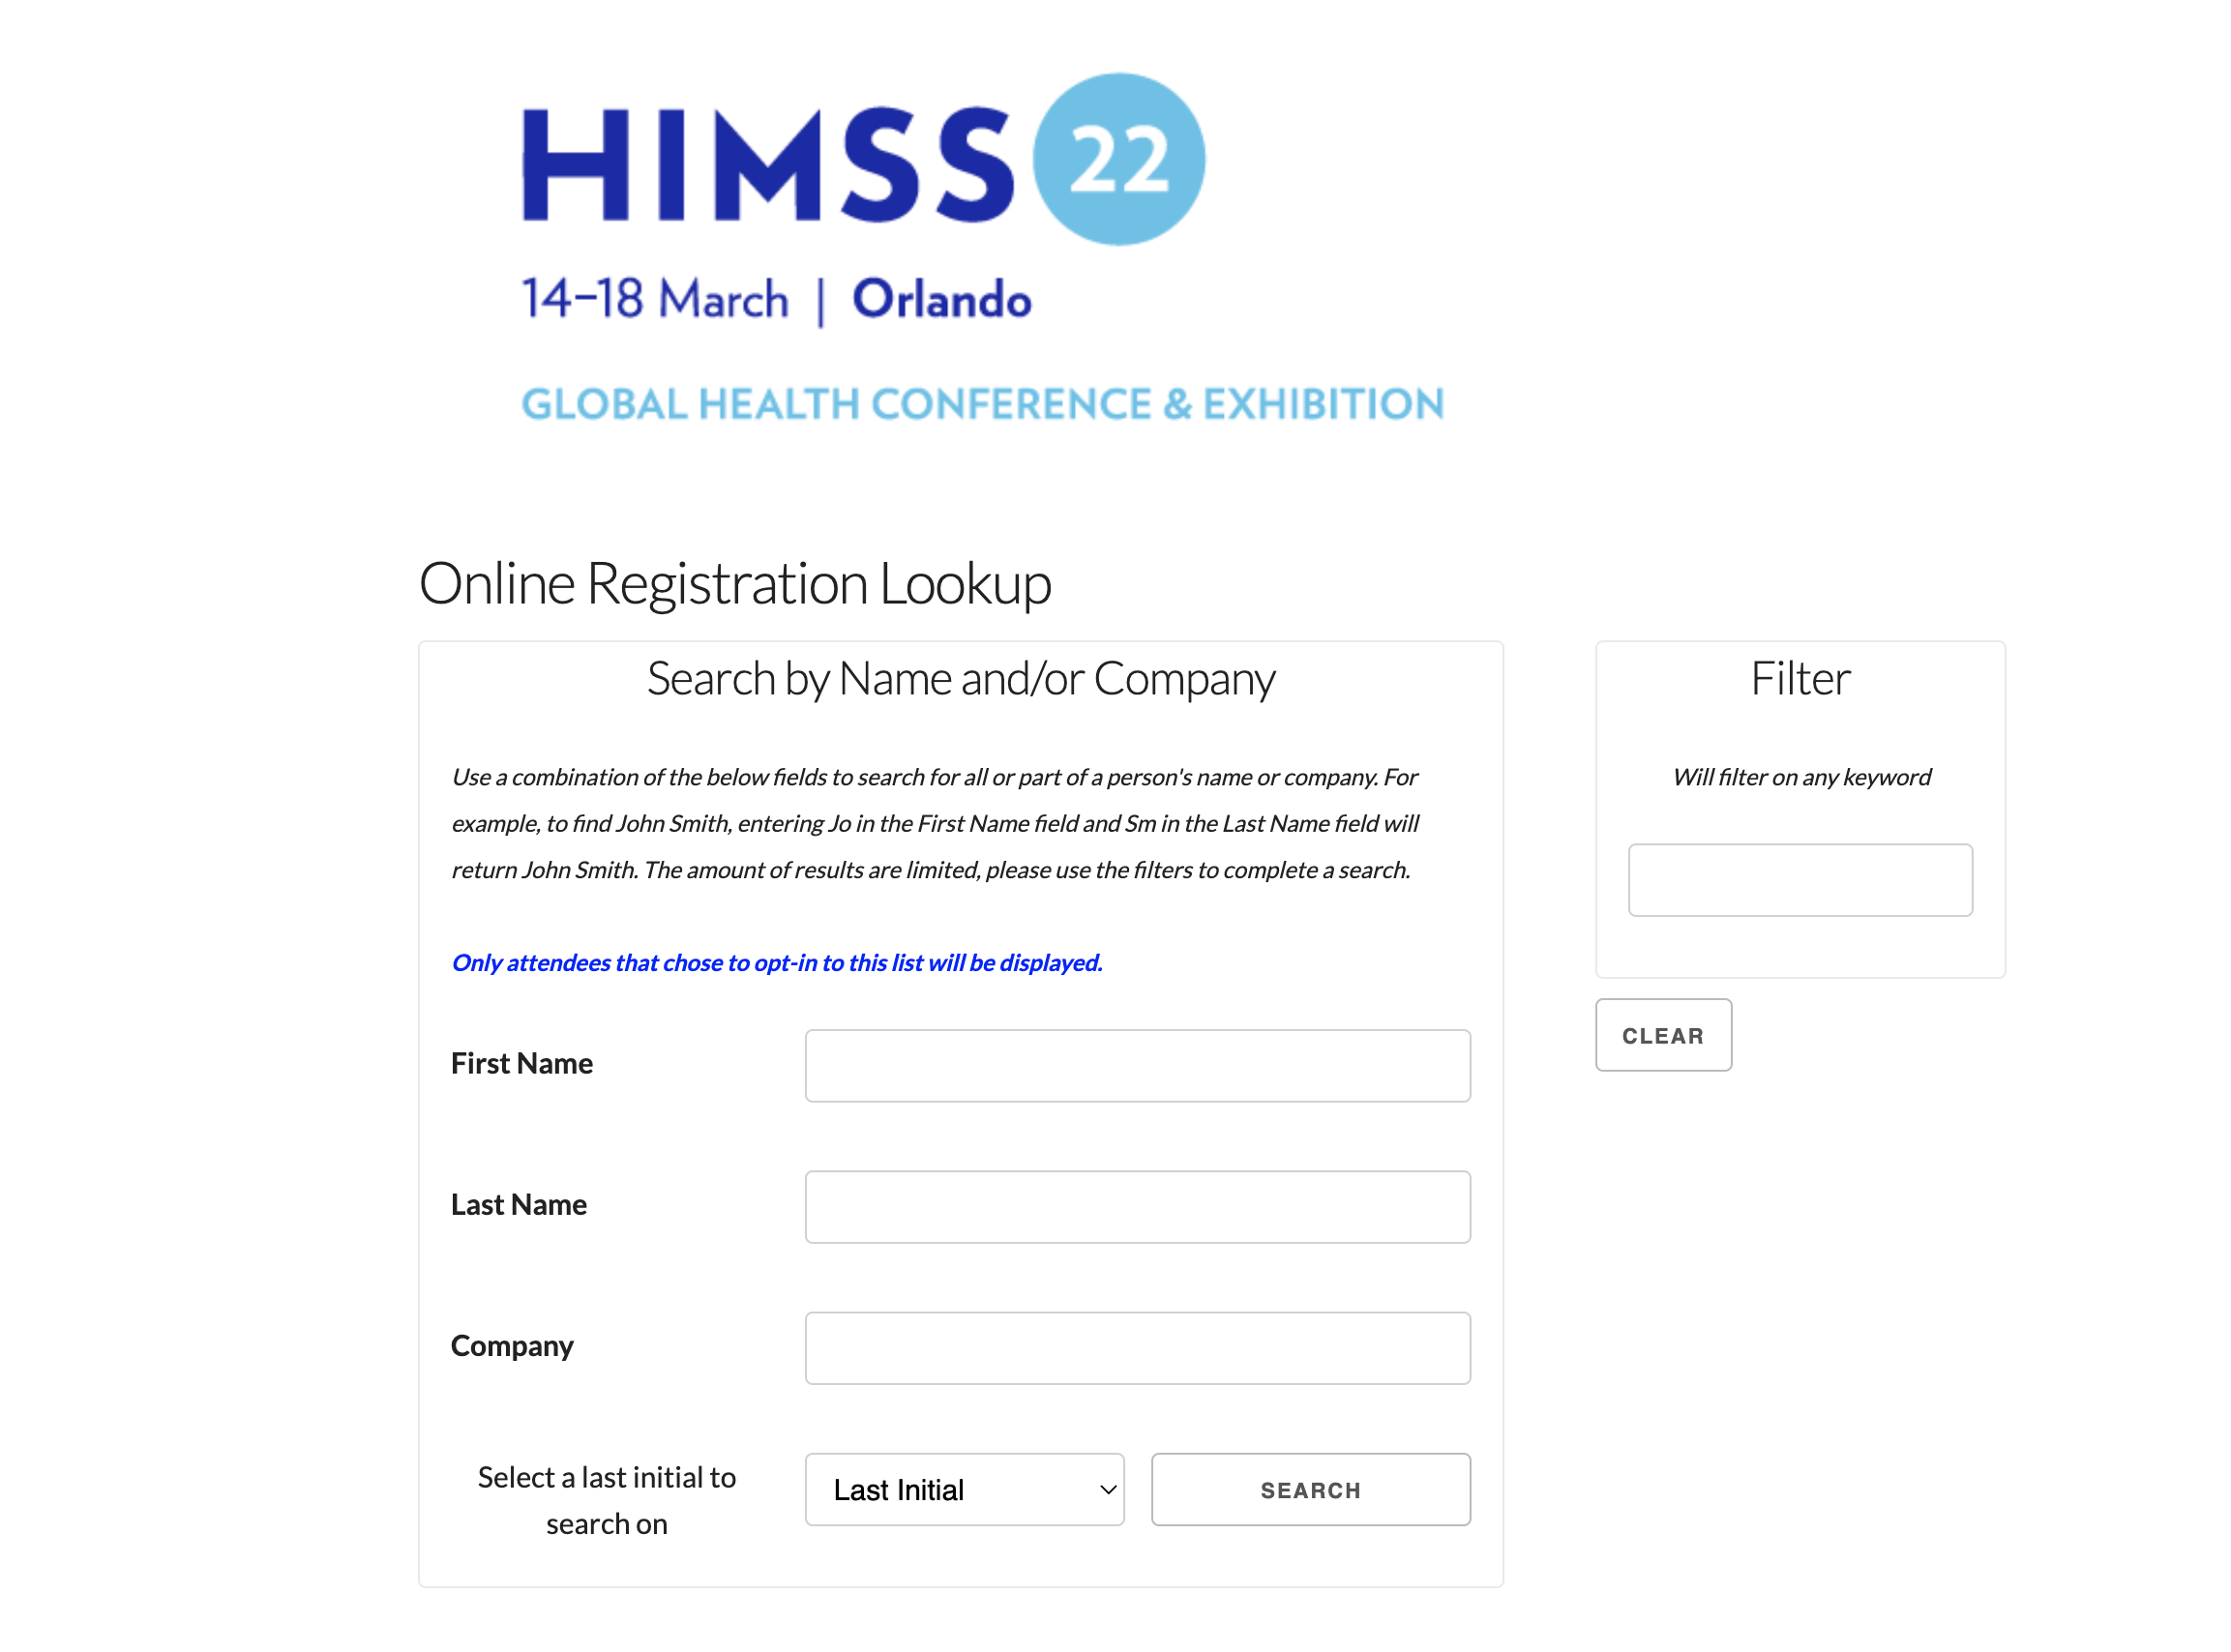

In [14]:
Image(filename="images/main-site.png")

The task is straightforward enough, but has the added complication that the form limits the number of results it will show you for any given query (in fact, it says so right on the page). Moreover, it does not tell you when it has limited the results it's showing you. 

The clients are aware of this and suggest circumventing the limitation by making a succession of last name queries for each letter of the alphabet joined pairwise to every other letter, including itself ("aa", "ab", "ac", ..., "ba", "bb", "bc", and so on). This does in fact work well for *almost* every case, but there are a couple two-letter combinations that *still* exceed the result limit.

Take "ma", for example. This query returns 483 results. Here's what the end of the results table looks like:

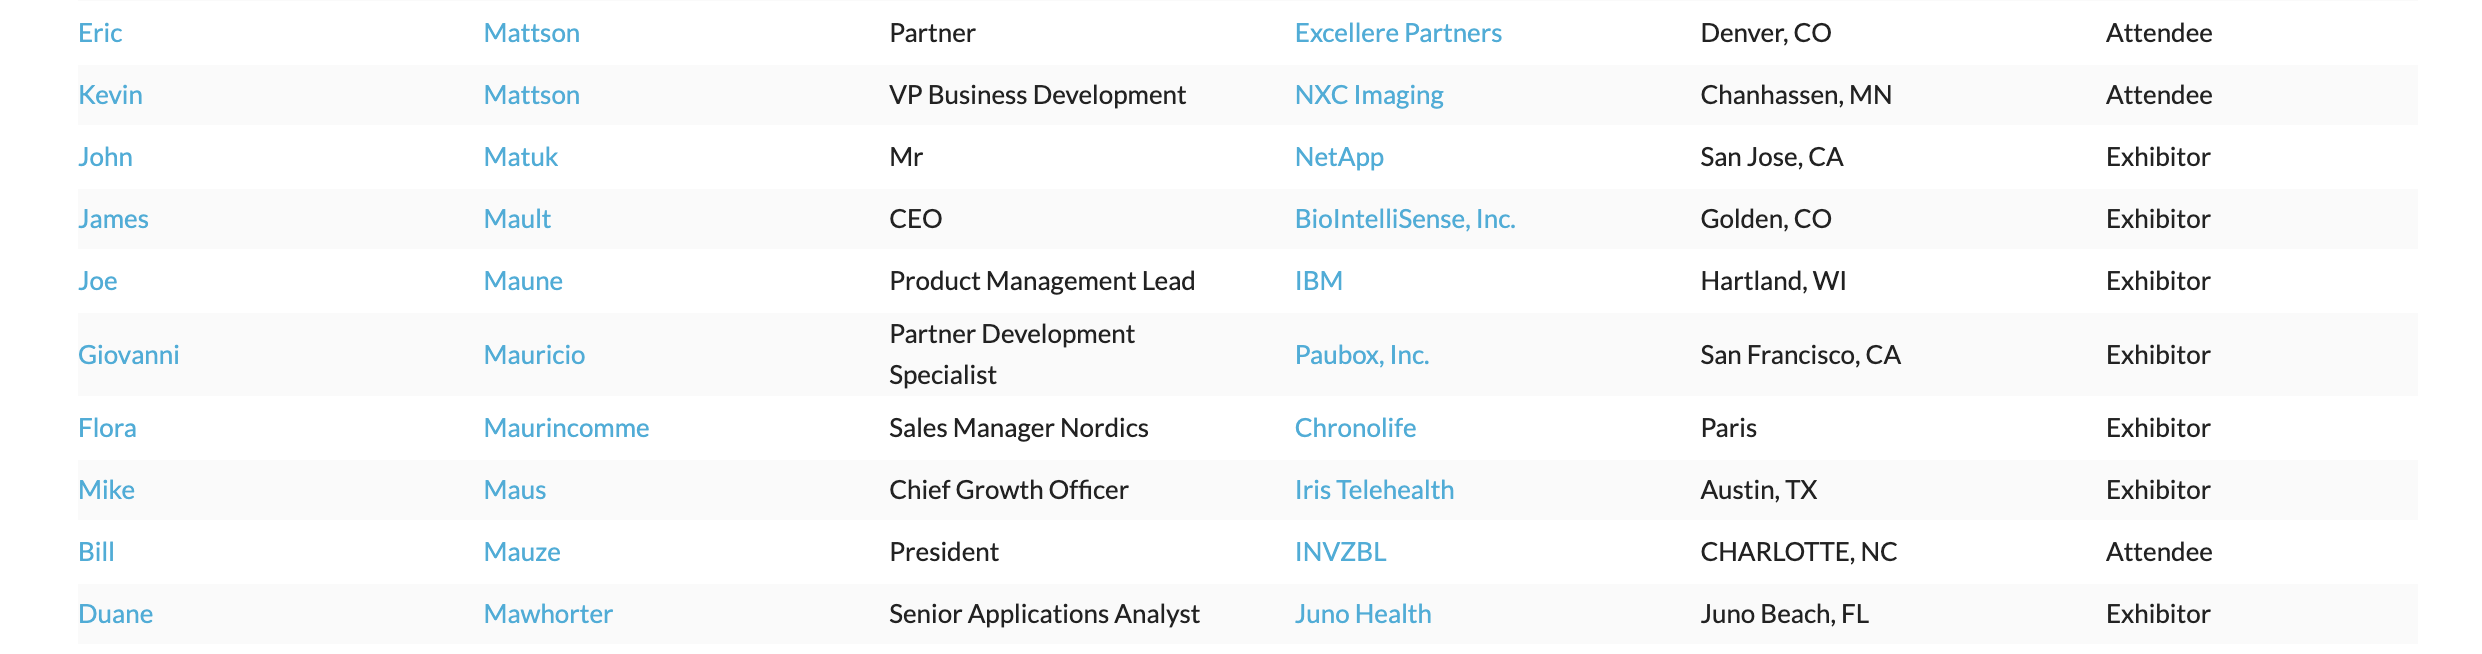

In [222]:
Image(filename="images/ma-end.png")

The results are alphabetical and end with the last name "Mawhorter". But what about last names beginning "May"? Surely there are some of those? Alas, indeed there are:

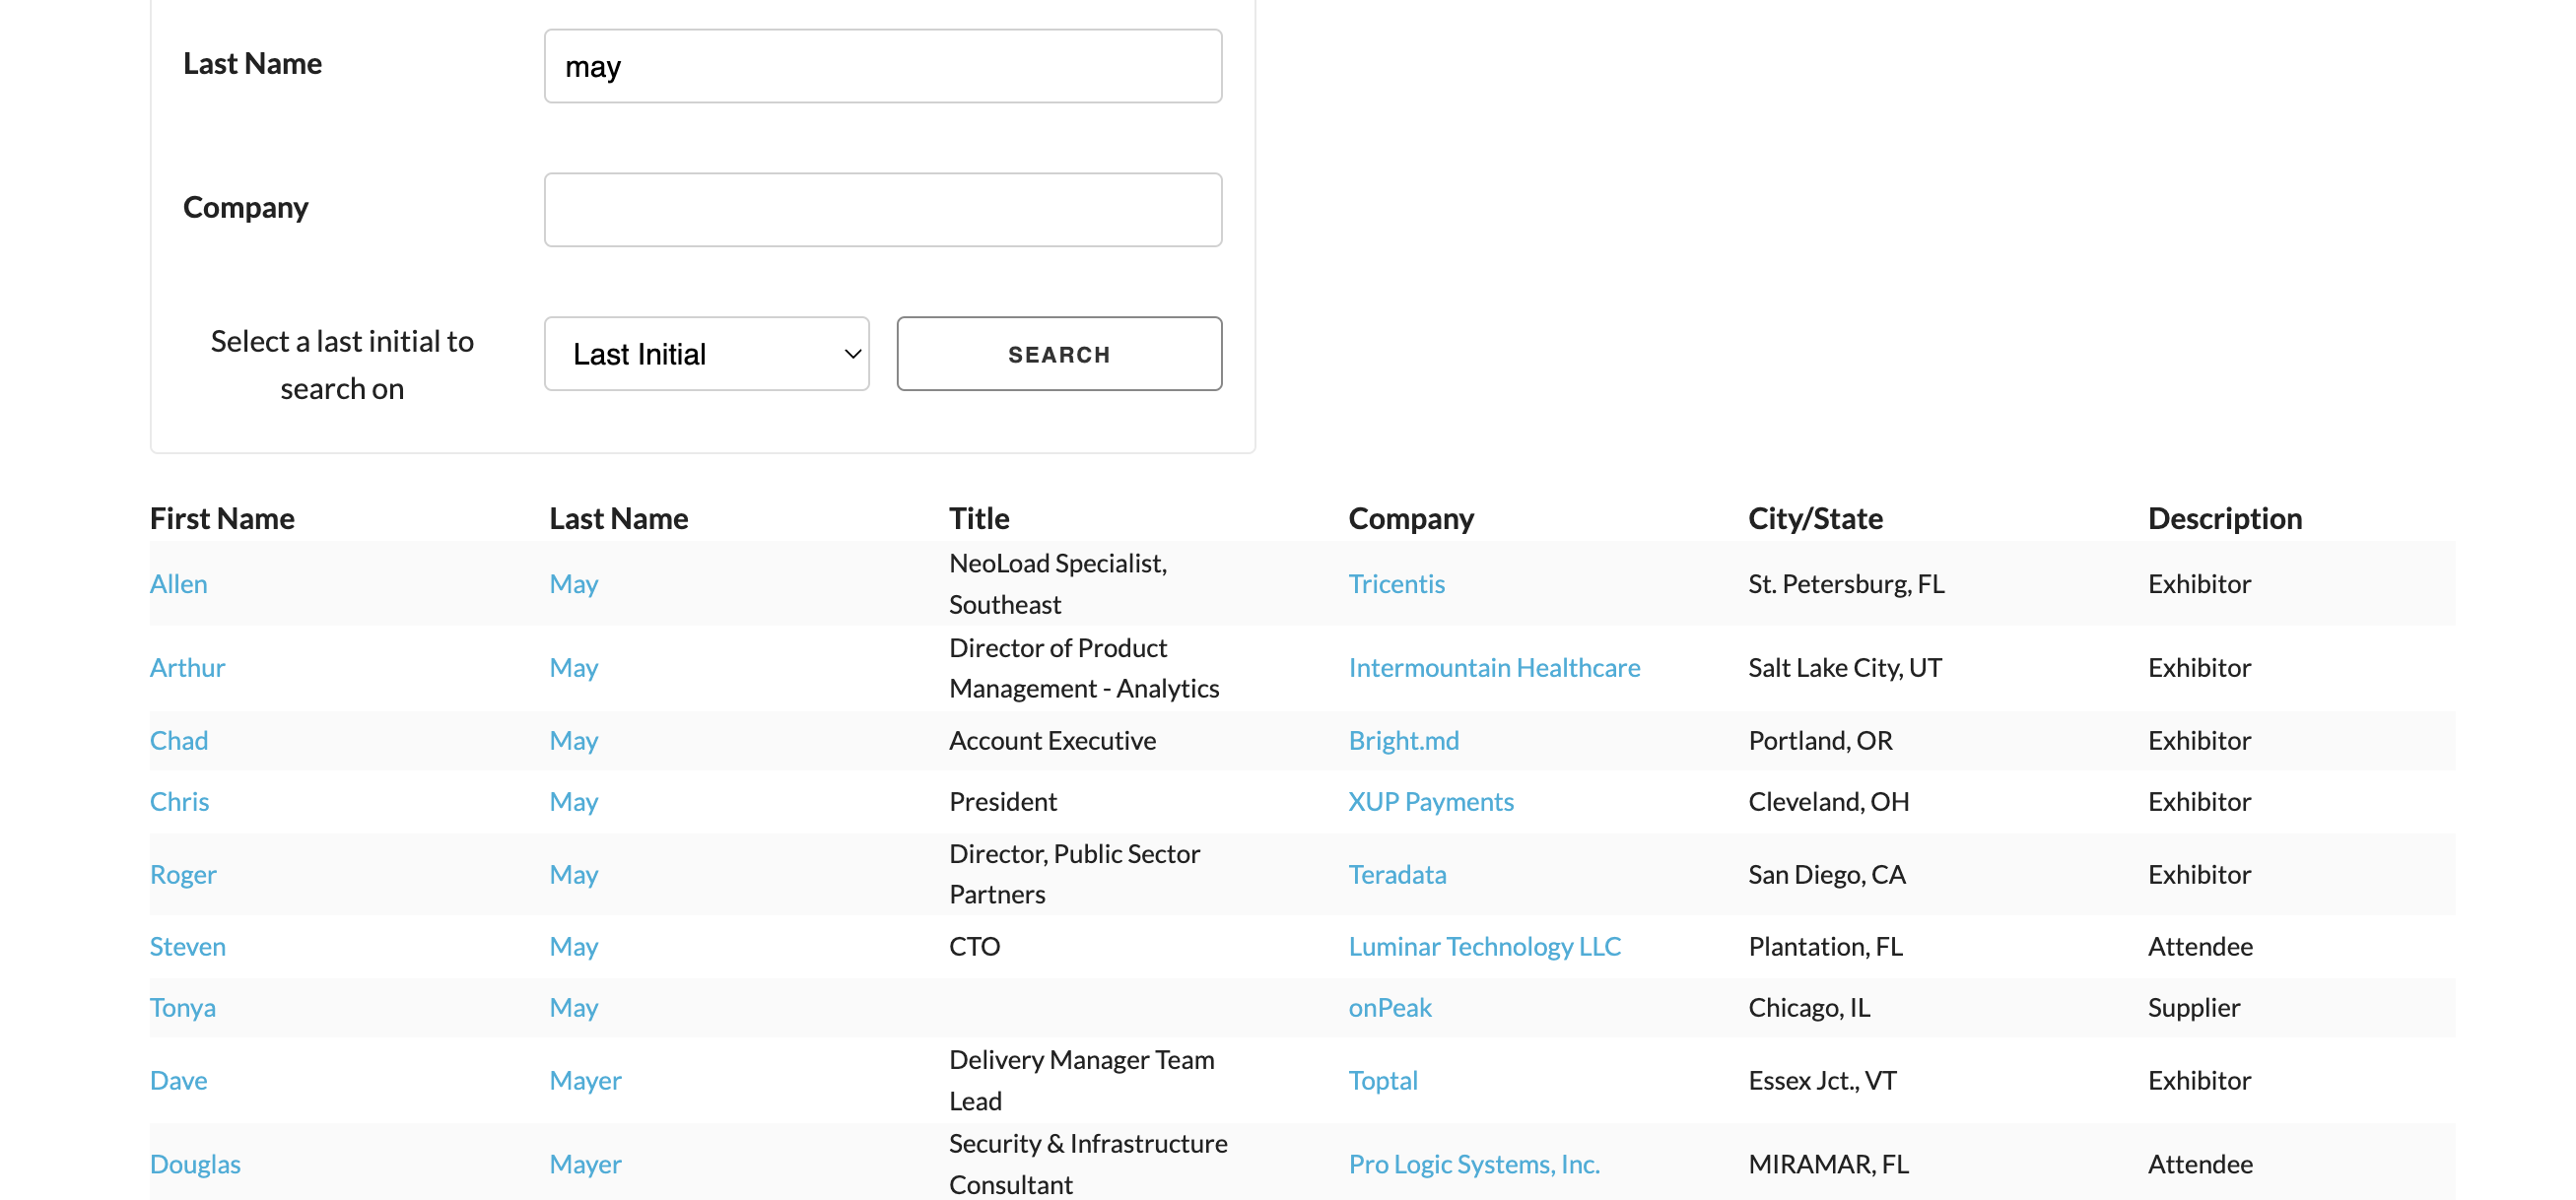

In [223]:
Image(filename="images/may.png")

This shows that the two-letter search strategy isn't sufficient on its own. We'll have to come up with something a bit more sturdy.

# Algorithm

To make sure we get every contact, we offer the following improved algorithm:

1. Set a result limit upon which, when observed, will require splitting the query into multiple smaller queries
    1. I observed that queries that surely hit the result limit would often return about 480-490 results. Hence, I set the threshold at a conservative 400.
2. FOR: each letter of the alphabet "a", "b", "c", ..., make an initial query for just the letter alone
    1. IF: the result set is less than the threshold, collect the results
    2. ELSE: 
        1. FOR: each letter, make pairwise queries with every other letter (e.g., "aa", "ab", ...)
            1. IF: the result set is less than the threshold, collect the results
            2. ELSE:
                1. FOR: each two letter combination, query each three-letter combination (e.g., "aaa", "aab", "aac", ...) 
                2. (continue recursively)
                

This algorithm works by making recursive calls to the function that forms the pairwise queries. Anytime it sees a query that exceeds the results limit, it will reject the incomplete result set and form 26 new queries (by appending each letter to the end of the existing query) to ensure all the results are gathered. Additionally, the added initial query for the single letter saves time and requests for letters that don't actually don't even need the two-letter splits (like "q", and "e", believe it or not).

# Browser Automation

Now that we have a working algorithm figured out, we're ready to begin automating the queries. Doing a quick test shows that the website isn't using query parameters to post our filled out form to the server (which is unfortunate, because that would have been convenient) so it looks like we're stuck automating in the browser. This being the case, I chose to do the automation using Python + Selenium.

The actual process of performing a query is straightforward:
1. Press the "CLEAR" button to clear any prior result set. This button is convenient and allows us to start each query from a clean slate.
2. Send the text of the query to the "last name" input box.
3. Press the "SEARCH" button, which has type="submit" to submit the form.

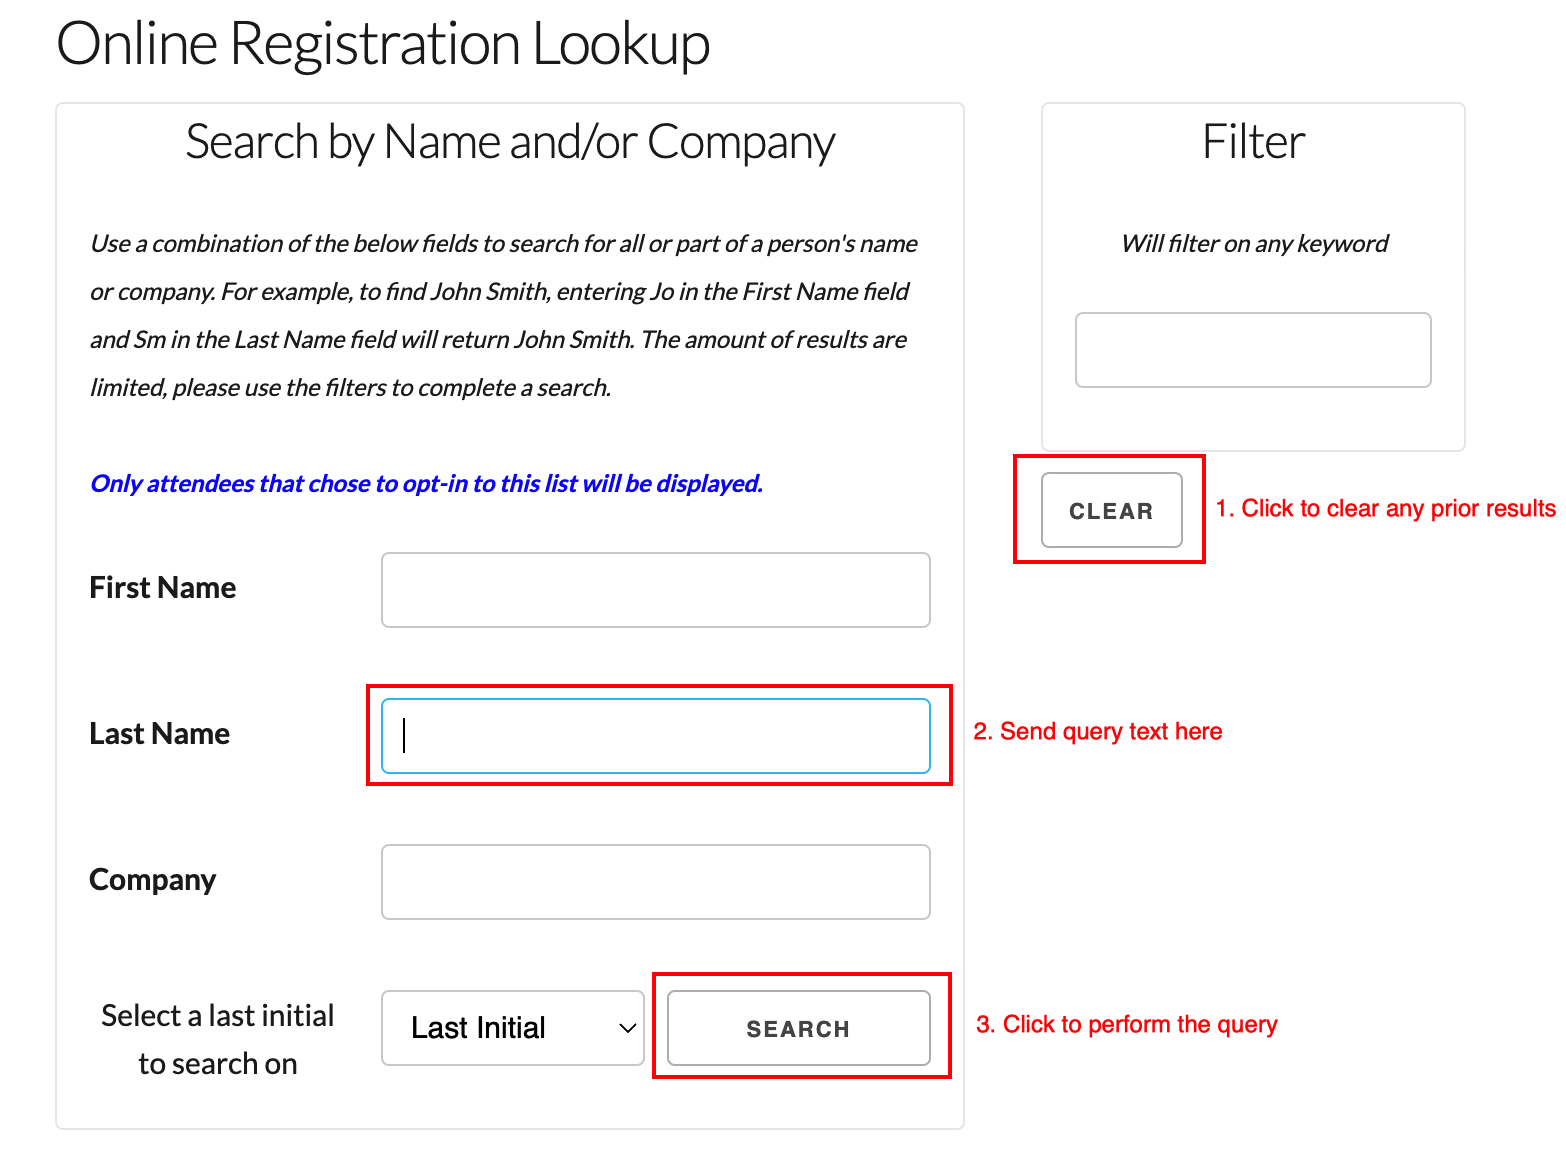

In [226]:
Image(filename="images/sequence.png")

The last minor complication is that we need to wait for the results to come back from our form submit before moving on to the next query. While we're waiting for results, the site shows a spinner:

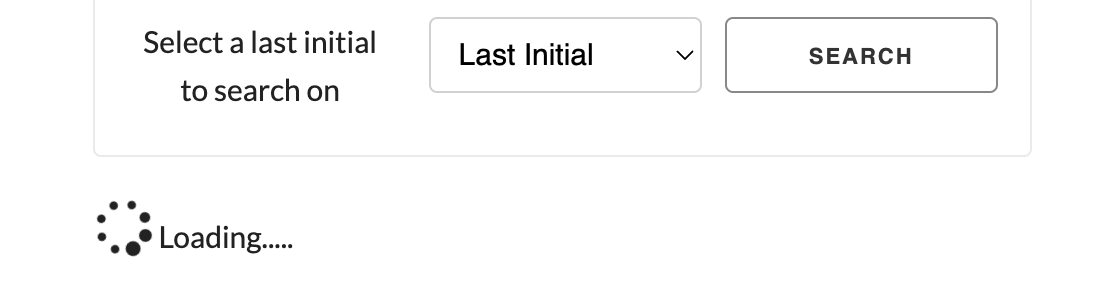

In [227]:
Image(filename="images/loading.png")

Though it seems like the results table is absent when waiting for results, an examination of the page's markup shows that it's actually always present, but only contains invisible elements (that is, those with "display: none;") when there's no results to show. That means we'll have to be creative and write a custom wait condition. 

Sparing you the gory details, an approach that proved sufficient was, after making the query:
1. Wait until a check for rows containing the people were present, or...
2. Wait until a row showing that there were no results is showing

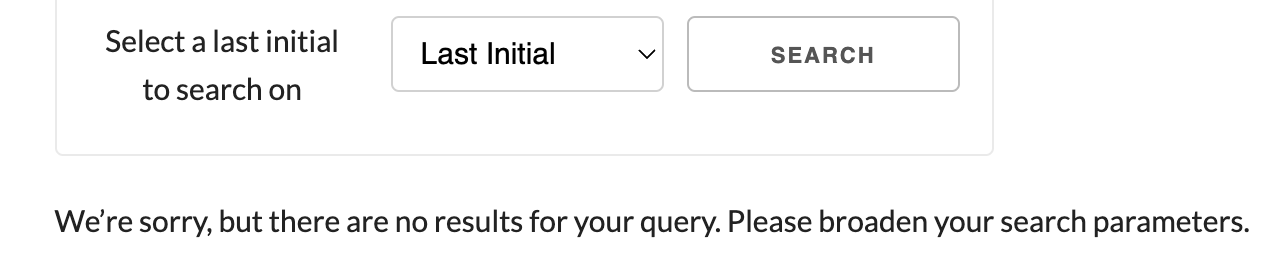

In [228]:
Image(filename="images/no-results.png")

That issue out of the way, we now have everything we need to perform the automation!

# Results

Our scrape runs without issue and returns a total of 17,079 results:

In [3]:
res

,First Name,Last Name,Title,Company,Loc,Desc
0,Juha,Aarvala,CEO,Clinical Research Institute Helsinki Universit...,Helsinki,Attendee
1,Osama,ABDELHAMIED,Inspector Pharmacist,Al Hosainia Health Administration,Al Hosainia,Attendee
2,Chris,Abad,Product Manager,Masimo,"Irvine, CA",Exhibitor
3,Sam,Abadir,"Director, Partnerships",TripleBlind,"Kansas City, MO",Exhibitor
4,Zeko,Abas,SALES MANAGER MOBILITY 3,AT&T Business,"Hazlet, NJ",Exhibitor
...,...,...,...,...,...,...
17074,Brian,Zweben,President,Innovative Precision Health,"New Castle, DE",Attendee
17075,Burt,Zweigenhaft,Editor in Chief,Value-Based Cancer Care,"New York, NY",Attendee
17076,Samantha,Zych,IDN Strategic Account Manager,Mindray North America,"Mahwah, NJ",Exhibitor
17077,chang,zhang,VP Technology,JACS solutions,"San Diego, CA",Attendee


Let's take a quick look at what we got just for fun. Here's the distribution of job titles that we pulled:

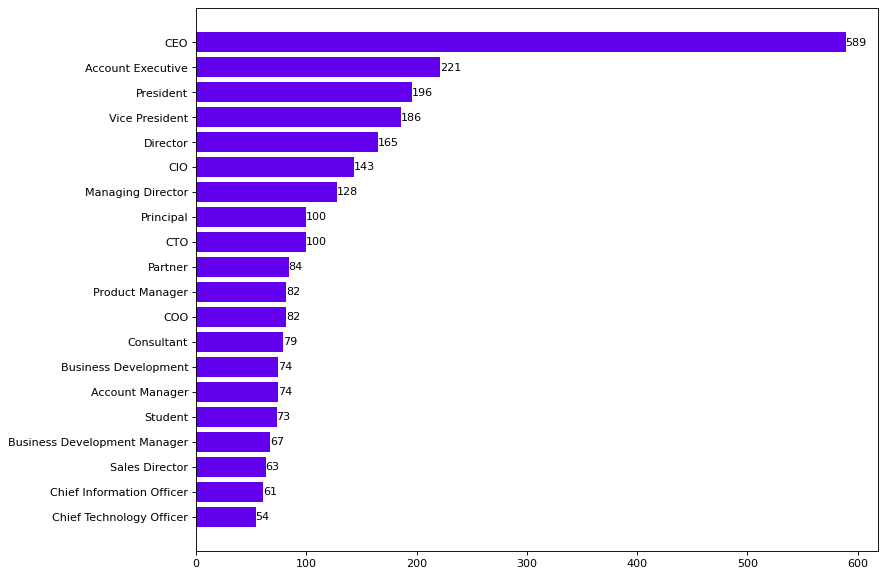

In [4]:
top = 20

vc = (
    res
    .Title
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Title", "Title": "Count"})
    .iloc[:top]
    .sort_values("Count")
)

fig, ax = plt.subplots(figsize=(11, 9), dpi=80)
bars = ax.barh(vc.Title, vc.Count, color="#6200EE")
ax.bar_label(bars)

plt.show()

Hmm...lots of big shots attending this one. How bout the "description"?

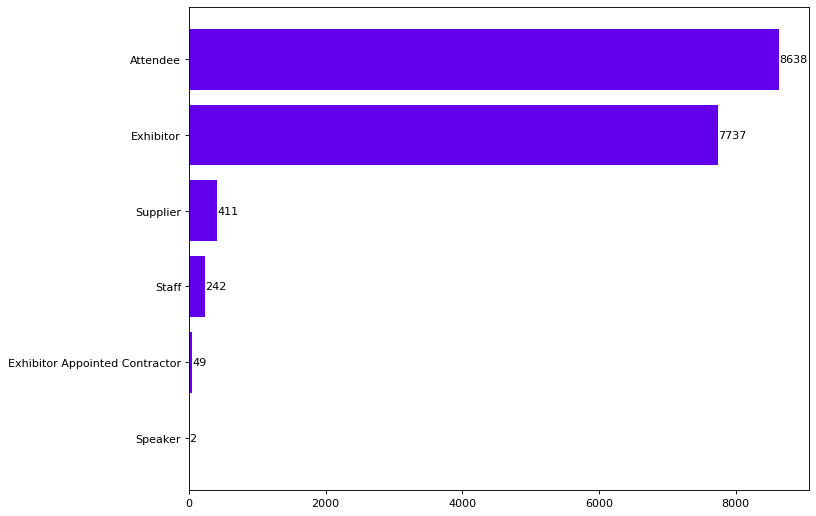

In [16]:
vc = (
    res
    .Desc
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Description", "Desc": "Count"})
    .sort_values("Count")
)

fig, ax = plt.subplots(figsize=(10, 8), dpi=80)
bars = ax.barh(vc.Description, vc.Count, color="#6200EE")
ax.bar_label(bars)

plt.show()

Not going to be a lot of speaking going on at this one.

Lastly, it would be good practice to provide our client with an exhaustive list of the queries we performed on their behalf along with the number of results as a sanity check. This way they can run the queries themselves and confirm our code worked as intended:

In [17]:
cnt

,Query,Result Count
0,aa,1
1,ab,47
2,ac,17
3,ad,44
4,ae,0
...,...,...
471,wy,16
472,wz,0
473,x,5
474,y,109


Looks like we ended up having to perform a total of 476 total searches in order to get all the contacts.

That's it, project ready to deliver 👍

Contact me on [Upwork](https://www.upwork.com/freelancers/~011742d1c3f2fe6be9) or [LinkedIn](https://www.linkedin.com/in/zpgallegos/) if you've got a data project you need done right!